In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Importing libraries**

In [5]:
# !pip install tqdm
# !pip install pyarrow

import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm, trange
from difflib import SequenceMatcher

plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 4.3 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# Prepare the datasets

In [7]:
annot = pd.read_parquet('text_ocr/annot.parquet')
img_fns = glob('text_ocr/train_val_images/train_images/*')
# annot, img_fns

(                          id          image_id  \
 0         a4ea732cd3d5948a_1  a4ea732cd3d5948a   
 1         a4ea732cd3d5948a_2  a4ea732cd3d5948a   
 2         a4ea732cd3d5948a_3  a4ea732cd3d5948a   
 3         a4ea732cd3d5948a_4  a4ea732cd3d5948a   
 4         a4ea732cd3d5948a_5  a4ea732cd3d5948a   
 ...                      ...               ...   
 1052349  0ebbecdc46b78d42_15  0ebbecdc46b78d42   
 1052350   a37e1fb026b80a6d_1  a37e1fb026b80a6d   
 1052351   a37e1fb026b80a6d_2  a37e1fb026b80a6d   
 1052352   a37e1fb026b80a6d_3  a37e1fb026b80a6d   
 1052353   a37e1fb026b80a6d_4  a37e1fb026b80a6d   
 
                                      bbox  utf8_string  \
 0            [525.83, 3.4, 197.64, 33.94]  Performance   
 1           [534.67, 64.68, 91.22, 38.19]        Sport   
 2           [626.95, 63.62, 96.52, 31.82]        Watch   
 3           [577.4, 141.87, 147.13, 43.1]   ...period.   
 4           [391.03, 163.9, 60.82, 38.65]            .   
 ...                            

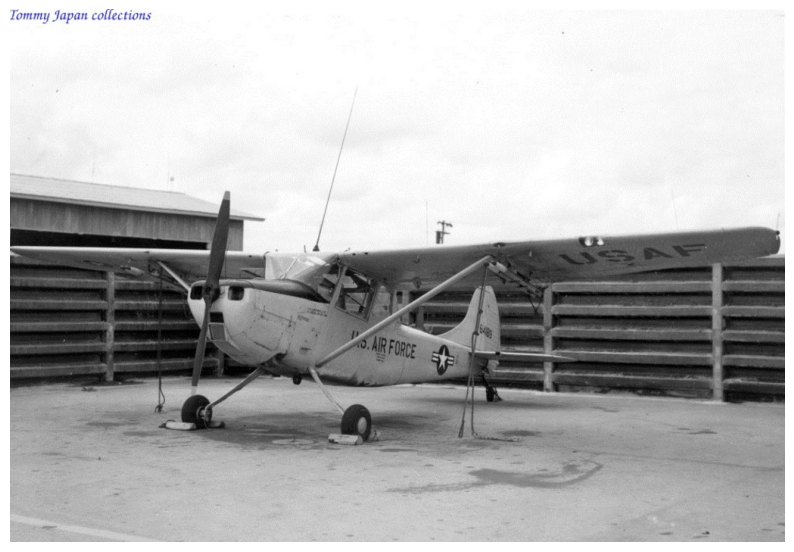

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[13]))
ax.axis('off')
plt.show()

In [9]:
len(img_fns)

18298

In [10]:
import pytesseract

# Example call
print(pytesseract.image_to_string(img_fns[13], lang='eng'))

# Pytesseract

In [14]:
####Loop through each image to extract text and save in df. Meanwhile calculate run time
import pytesseract
from pytesseract import Output
from tqdm import tqdm, trange
from difflib import SequenceMatcher


#create an empty dataframe
# df=pd.DataFrame(columns = ['image_id', 'text'])
df_data = []

#loop through each image and append results
for i in trange(10): #(1000)):
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    data=pytesseract.image_to_data(img_fns[i],output_type=Output.DATAFRAME )
    data['image_id'] = image_id
    df_data.append(data[['image_id','text']])
    # df = df.append(data[['image_id','text']],ignore_index=True)

df = pd.DataFrame(df_data)

#df.to_csv(r'\Users\magzhang\Documents\ray.csv', index=False)
#remove NaN and missing values from df
df1=df[(df.text!=' ')].dropna().astype(str)

#concatenate text field by groupby image_id
df2=df1.sort_values('text').groupby(['image_id'], as_index=False).agg({'text': ' '.join})
annot_agg=annot[['image_id','utf8_string']].sort_values('utf8_string').groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})

final_p=annot_agg.merge(df2, how='inner', left_on='image_id',right_on='image_id')

def apply_sm(df):
    if not df[['utf8_string', 'text']].isnull().any():
        return SequenceMatcher(None, df['utf8_string'], df['text']).ratio()
    return 0.0
final_p['ratio']=final_p.apply(apply_sm,axis=1)
final_p["ratio"].mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 62/1000 [01:05<19:29,  1.25s/it]

# Modified OCR

In [8]:
#define function to identify if handwritting
import cv2
def is_handwritten(im):
# Find contours in the edged image   
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    is_handwritten = False
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        #print(aspect_ratio)
        if aspect_ratio < 1:
            return True
        else:
            return False

In [9]:
im = cv2.imread(img_fns[15])
is_handwritten(im)

False

In [10]:
import pytesseract
from pytesseract import Output
from tqdm import tqdm, trange
from difflib import SequenceMatcher
import easyocr
reader = easyocr.Reader(['en'], gpu = True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
####Loop through each image to extract text and save in df. Meanwhile calculate run time


#create an empty dataframe
df=pd.DataFrame(columns = ['image_id', 'text'])

#loop through each image and append results
for i in trange(1000):
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    im = cv2.imread(img_fns[i])
    if is_handwritten(im):
        data=pytesseract.image_to_data(img_fns[i],output_type=Output.DATAFRAME )
    else:
        results = reader.readtext(img_fns[i])
        data=pd.DataFrame(results, columns=['bbox','text','conf'])
    
    data['image_id']=image_id
    df=df.append(data[['image_id','text']],ignore_index=True)

    
df1=df[(df.text!=' ')].dropna().astype(str)

#concatenate text field by groupby image_id
df2=df1.sort_values('text').groupby(['image_id'], as_index=False).agg({'text': ' '.join})
annot_agg=annot[['image_id','utf8_string']].sort_values('utf8_string').groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})

final_p=annot_agg.merge(df2, how='inner', left_on='image_id',right_on='image_id')

def apply_sm(df):
    if not df[['utf8_string', 'text']].isnull().any():
        return SequenceMatcher(None, df['utf8_string'], df['text']).ratio()
    return 0.0
final_p['ratio']=final_p.apply(apply_sm,axis=1)
final_p["ratio"].mean()

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_23/2694181547.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 1/1000 [00:00<04:07,  4.03it/s]/tmp/ipykernel_23/2694181547.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 2/1000 [00:00<03:51,  4.32it/s]/tmp/ipykernel_23/2694181547.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 3/1000 [00:00<03:48,  4.36it/s]/tmp/ipykernel_23/2694181547.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

0.33246882732372685

# Easy OCR

In [12]:
import easyocr
reader = easyocr.Reader(['en'], gpu = True)

In [13]:
#create an empty dataframe
df=pd.DataFrame(columns = ['image_id', 'text'])

#loop through each image and append results
for i in trange(1000):
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    results = reader.readtext(img_fns[i])
    data=pd.DataFrame(results, columns=['bbox','text','conf'])
    data['image_id']=image_id
    df=df.append(data[['image_id','text']],ignore_index=True)


df1=df[(df.text!=' ')].dropna().astype(str)

#concatenate text field by groupby image_id
df2=df1.sort_values('text').groupby(['image_id'], as_index=False).agg({'text': ' '.join})
annot_agg=annot[['image_id','utf8_string']].sort_values('utf8_string').groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})

final_p=annot_agg.merge(df2, how='inner', left_on='image_id',right_on='image_id')

def apply_sm(df):
    if not df[['utf8_string', 'text']].isnull().any():
        return SequenceMatcher(None, df['utf8_string'], df['text']).ratio()
    return 0.0
final_p['ratio']=final_p.apply(apply_sm,axis=1)
final_p["ratio"].mean()

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_23/3725879859.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 1/1000 [00:00<03:14,  5.12it/s]/tmp/ipykernel_23/3725879859.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 2/1000 [00:00<04:30,  3.70it/s]/tmp/ipykernel_23/3725879859.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data[['image_id','text']],ignore_index=True)
  0%|          | 3/1000 [00:00<04:30,  3.68it/s]/tmp/ipykernel_23/3725879859.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

0.3368264511707105